In [3]:
import os

os.environ["CHECKPOINTS_PATH"] = "../checkpoints"
os.environ["TRACKING_RESULTS_PATH"] = "data/processed_tracking_results"

import itertools
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from src.api.models.pydantic import SimRoomClassDTO
from src.config import UNKNOWN_CLASS_ID, TOBII_GLASSES_FPS, VIEWED_RADIUS
from ultralytics import YOLO
import subprocess

from experiment.settings import (
    CLASS_ID_TO_NAME,
    FULLY_LABELED_RECORDINGS,
    GAZE_SEGMENTATION_RESULTS_PATH,
    RECORDINGS_PATH,
    RECORDING_FRAMES_PATH,
    OBJECT_DETECTION_MODELS_PATH,
    COMPARISON_SETS_PATH,
    NAME_TO_CLASS_ID,
    OBJECT_DETECTION_PREDICTIONS_PATH,
    FINAL_PREDICTION_VIDEOS_PATH,
    IGNORED_CLASS_IDS
)
from src.api.db import Session, engine
from src.api.repositories import simrooms_repo
from src.api.services import simrooms_service, gaze_service
import cv2
import numpy as np
import tempfile
from src.utils import extract_frames_to_dir
import albumentations as A
from tqdm import tqdm
import json
from torchvision.ops import box_iou
import torch
import collections
from src.api.utils import image_utils
from experiment import experiment_utils
from experiment.experiment_utils import (
    CMMetrics
)
import multiprocessing
import functools
import itertools

IMG_CROP_SIZE = 640
IMG_CROP_SIZE_HALF = IMG_CROP_SIZE // 2

models = list(OBJECT_DETECTION_MODELS_PATH.glob("*.pt"))

# Object Detection Inference

## Inference - Create Comparison Sets

In [2]:
def get_frame_to_gaze_segmentation_data(
    gaze_segmentation_results_path: Path,
):
    if not gaze_segmentation_results_path.exists():
        raise ValueError(
            f"Gaze segmentation results path {gaze_segmentation_results_path} does not exist. Please run the gaze segmentation pipeline first."
        )

    frame_to_gaze_segmentation_data = {}
    for result in gaze_segmentation_results_path.glob("*.npz"):
        file = np.load(result)
        frame_idx = file["frame_idx"]
        frame_to_gaze_segmentation_data[int(frame_idx)] = {
            "gaze_position": tuple(file["gaze_position"].tolist()),
            "boxes": file["boxes"],
            "object_ids": file["object_ids"].tolist(),
            "confidences": file["confidences"].tolist(),
        }

    return frame_to_gaze_segmentation_data

def get_comparison_set(
    recording_id: str,
    model: YOLO,
):
    # Get frames for the recording
    recording_frames_path = RECORDING_FRAMES_PATH / recording_id
    frames = list(recording_frames_path.glob("*.jpg"))

    # Get gaze segmentation data for the recording
    gaze_segmentation_results_path = GAZE_SEGMENTATION_RESULTS_PATH / recording_id
    frame_to_gaze_segmentation_data = get_frame_to_gaze_segmentation_data(
        gaze_segmentation_results_path
    )

    # Get gaze positions for the recording
    frame_to_gaze_position = gaze_service.get_gaze_position_per_frame(recording_id, len(frames))

    # Create comparison set
    comparison_set_per_frame = {}
    for frame_path in tqdm(frames, desc=f"Running inference for {recording_id}"):
        frame_idx = int(frame_path.stem)
        if frame_to_gaze_segmentation_data.get(frame_idx) is None:
            continue

        image = cv2.imread(str(frame_path))
        gaze_segmentation_confidences = frame_to_gaze_segmentation_data[frame_idx]["confidences"]
        gaze_segmentation_boxes = frame_to_gaze_segmentation_data[frame_idx]["boxes"]
        gaze_segmentation_object_ids = frame_to_gaze_segmentation_data[frame_idx]["object_ids"]

        # Create a crop around the gaze position
        cx, cy = frame_to_gaze_position[frame_idx]
        x_min = max(0, cx - IMG_CROP_SIZE_HALF)
        y_min = max(0, cy - IMG_CROP_SIZE_HALF)
        x_max = min(image.shape[1], cx + IMG_CROP_SIZE_HALF)
        y_max = min(image.shape[0], cy + IMG_CROP_SIZE_HALF)

        transform = A.Compose([                
                A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max),
                A.PadIfNeeded(min_height=IMG_CROP_SIZE, min_width=IMG_CROP_SIZE),
            ],
            bbox_params=A.BboxParams(
                format="pascal_voc", label_fields=["object_ids"], min_visibility=0.7
            ),
        )

        transformed = transform(
            image=image, 
            bboxes=gaze_segmentation_boxes, 
            object_ids=gaze_segmentation_object_ids
        )
        transformed_image = transformed["image"]
        transformed_gaze_segmentation_boxes = transformed["bboxes"]
        transformed_gaze_segmentation_object_ids = transformed["object_ids"]

        # Run inference on the crop
        results = model.predict(
            source=transformed_image,
            conf=0.5,
            iou=0.5,
            device="cuda",
            verbose=False
        )

        predicted_confidences = []
        predicted_bboxes = []
        predicted_class_ids = []
        for box in results[0].boxes:
            conf = float(box.conf[0].cpu().numpy())
            class_id = int(box.cls[0])
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            predicted_confidences.append(conf)
            predicted_bboxes.append((int(x1), int(y1), int(x2), int(y2)))
            predicted_class_ids.append(class_id)


        comparison_set_per_frame[frame_idx] = {
            "gaze_segmentation": {
                "boxes": transformed_gaze_segmentation_boxes.astype(np.int32).tolist(),
                "object_ids": transformed_gaze_segmentation_object_ids,
                "confidences": gaze_segmentation_confidences,
            },
            "predicted": {
                "boxes": predicted_bboxes,
                "class_ids": predicted_class_ids,
                "confidences": predicted_confidences,
            },
        }
    
    return comparison_set_per_frame

In [4]:
for model in models:
    model_name = model.stem
    model_comparison_sets_path = COMPARISON_SETS_PATH / model_name
    
    if model_comparison_sets_path.exists():
        shutil.rmtree(model_comparison_sets_path)
    model_comparison_sets_path.mkdir(parents=True, exist_ok=True)

    print(f"Running inference for model {model_name} on {len(FULLY_LABELED_RECORDINGS)} fully labeled recordings")
    for recording_id in FULLY_LABELED_RECORDINGS:
        comparison_set_path = model_comparison_sets_path / f"{recording_id}.json"

        comparison_set_per_frame = get_comparison_set(
            recording_id=recording_id,
            model=YOLO(model)
        )

        with open(comparison_set_path, "w") as f:
            f.write(json.dumps(comparison_set_per_frame, indent=4))
        

Running inference for model 2000_samples on 10 fully labeled recordings


Running inference for 67b71a70-da64-467a-9fb6-91bc29265fd1: 100%|██████████| 2064/2064 [00:17<00:00, 118.42it/s]


Running inference for 32f02db7-adc0-4556-a2da-ed2ba60a58c9: 100%|██████████| 1365/1365 [00:16<00:00, 81.96it/s]


Running inference for b8eeecc0-06b1-47f7-acb5-89aab3c1724d: 100%|██████████| 1557/1557 [00:12<00:00, 123.64it/s]


Running inference for d50c5f3b-2822-4462-9880-5a8f0dd46bfb: 100%|██████████| 1500/1500 [00:16<00:00, 88.74it/s] 
Running inference for 9fa3e3b8-ed94-4b06-ba49-e66e3997d710: 100%|██████████| 1229/1229 [00:11<00:00, 106.81it/s]
Running inference for 98128cdc-ffeb-40cb-9528-573e25028e87: 100%|██████████| 1543/1543 [00:19<00:00, 80.66it/s] 
Running inference for 89b60530-e0e4-4f5d-9ee6-af85c8d99ff4: 100%|██████████| 1270/1270 [00:10<00:00, 119.65it/s]


Running inference for 2fe01600-c057-40ee-8434-4e9e0688ca2d: 100%|██████████| 2041/2041 [00:24<00:00, 83.73it/s] 


Running inference for 67823ccd-a1f0-4cde-b954-3b9e5fe160c1: 100%|██████████| 1554/1554 [00:17<00:00, 87.42it/s] 
Running inference for b8f453aa-5a12-4cbb-a0ec-20eb503f8797: 100%|██████████| 1364/1364 [00:13<00:00, 98.93it/s]


### Validate Comparison Sets

In [88]:
def uncrop_box(
    box,
    gaze_position: tuple[int, int],
    image_width: int,
    image_height: int,
) -> tuple[int, int, int, int]:
    IMG_CROP_SIZE = 640
    IMG_CROP_SIZE_HALF = IMG_CROP_SIZE // 2

    cx, cy = gaze_position
    x_min = max(0, cx - IMG_CROP_SIZE_HALF)
    y_min = max(0, cy - IMG_CROP_SIZE_HALF)

    x1, y1, x2, y2 = box
    x1 = int(x1 + x_min)
    y1 = int(y1 + y_min)
    x2 = int(x2 + x_min)
    y2 = int(y2 + y_min)

    return (x1, y1, x2, y2)

def create_comparison_set_validation_video(
    class_names: dict[int, str],
    comparison_set: dict,
    recording_id: str,
    video_result_path: Path
):
    print("Extracting frames")
    frames, tmp_frames_dir = simrooms_service.extract_tmp_frames(recording_id)
    tmp_frames_path = Path(tmp_frames_dir.name)

    frame_to_gaze_position = gaze_service.get_gaze_position_per_frame(recording_id, frame_count=len(frames))

    print("Drawing frames")
    for frame_path in tqdm(frames):
        frame_idx = int(frame_path.stem)
        
        if comparison_set.get(str(frame_idx)) is None:
            continue
        
        gx, gy = frame_to_gaze_position[frame_idx]

        frame_comparison_set = comparison_set[str(frame_idx)]
        image = cv2.imread(str(frame_path))

        gs_boxes = frame_comparison_set["gaze_segmentation"]["boxes"]
        gs_object_ids = frame_comparison_set["gaze_segmentation"]["object_ids"]
        gs_confidences = frame_comparison_set["gaze_segmentation"]["confidences"]

        predicted_boxes = frame_comparison_set["predicted"]["boxes"]
        predicted_class_ids = frame_comparison_set["predicted"]["class_ids"]
        predicted_confidences = frame_comparison_set["predicted"]["confidences"]

        gs_metadata = zip(gs_boxes, gs_object_ids, gs_confidences)
        pred_metadata = zip(predicted_boxes, predicted_class_ids, predicted_confidences)

        for box, object_id, confidence in gs_metadata:
            box = uncrop_box(
                box=box,
                gaze_position=(gx, gy),
                image_width=image.shape[1],
                image_height=image.shape[0],
            )
            image = image_utils.draw_labeled_box(
                img=image,
                box=box,
                label=f"GS: {object_id} {confidence:.2f}",
                color="#FF0000",
            )
        
        for box, class_id, confidence in pred_metadata:
            box = uncrop_box(
                box=box,
                gaze_position=(gx, gy),
                image_width=image.shape[1],
                image_height=image.shape[0],
            )
            image = image_utils.draw_labeled_box(
                img=image,
                box=box,
                label=f"{class_names[class_id]} {confidence:.2f}",
                color="#00FF00",
            )

        # Draw gaze position
        image = cv2.circle(image, (gx, gy), VIEWED_RADIUS, (0, 0, 255), -1)

        # Draw frame index in top left corner of the video
        cv2.putText(
            image,
            f"Frame: {frame_idx}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (255, 255, 255),
            2,
        )

        # in the bottom left, draw a list of all object ids that were detected in the frame
        object_ids = set(gs_object_ids + predicted_class_ids)
        object_ids_text = "Objects: " + ", ".join(
            [f"{object_id}" for object_id in object_ids if object_id not in IGNORED_CLASS_IDS]
        )
        cv2.putText(
            image,
            object_ids_text,
            (10, image.shape[0] - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 255),
            1,
        )

        # in the bottom right, above the object ids, draw the class ids in this frame (NOT OBJECT IDS)
        class_ids_text = "Class IDs: " + ", ".join(
            [f"{class_id}" for class_id in set(predicted_class_ids) if class_id not in IGNORED_CLASS_IDS]
        )
        cv2.putText(
            image,
            class_ids_text,
            (image.shape[1] - 200, image.shape[0] - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 255),
            1,
        )

        # save image
        cv2.imwrite(frame_path, image)

    print(f"Creating video for {recording_id}")
    cmd = f'ffmpeg -hwaccel cuda -y -pattern_type glob -framerate {TOBII_GLASSES_FPS} -i "{str(tmp_frames_path)!s}/*.jpg" -c:v libx264 -pix_fmt yuv420p "{str(video_result_path)}"'
    subprocess.run(cmd, shell=True)

COMPARISON_SET_VALIDATION_VIDEOS_PATH = Path("data/comparison_set_validation_videos")
if COMPARISON_SET_VALIDATION_VIDEOS_PATH.exists():
    shutil.rmtree(COMPARISON_SET_VALIDATION_VIDEOS_PATH)
COMPARISON_SET_VALIDATION_VIDEOS_PATH.mkdir(parents=True, exist_ok=True)

for model in models:
    model_name = model.stem
    yolo_model = YOLO(model)
    names = yolo_model.names
    
    video_results_path = COMPARISON_SET_VALIDATION_VIDEOS_PATH / model_name
    if not video_results_path.exists():
        video_results_path.mkdir(parents=True, exist_ok=True)
    
    comparison_sets = (COMPARISON_SETS_PATH / model_name).iterdir()
    for comparison_set_path in comparison_sets:
        recording_id = comparison_set_path.stem
        if recording_id != "89b60530-e0e4-4f5d-9ee6-af85c8d99ff4":
            continue

        comparison_set = json.loads(comparison_set_path.read_text())

        create_comparison_set_validation_video(
            names,
            comparison_set=comparison_set,
            recording_id=comparison_set_path.stem,
            video_result_path=video_results_path / f"{comparison_set_path.stem}.mp4",
        )

Extracting frames
Drawing frames


100%|██████████| 1270/1270 [00:06<00:00, 201.44it/s]
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable

Creating video for 89b60530-e0e4-4f5d-9ee6-af85c8d99ff4


[libx264 @ 0x55efe2c88280] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x55efe2c88280] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=24 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=24 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to 'data/comparison_set_validation_videos/2000_samples/89b60530-e0e4-4f5d-9ee6-af85c8d99ff4.mp4':
  Metadata:
    encoder         : Lavf58.76.100
  Stream #0:0: Video: h264 (avc1 / 0x31637661), yuv420p(tv, bt470bg/unknown/unknow

## Inference - Intersect Comparison Sets

In [ ]:
def get_viewed_boxes_per_frame(
    comparison_set: dict,
    min_pred_conf: float,
    iou_threshold: float,
):
    viewed_boxes_per_frame = {}

    for frame_idx, frame_data in comparison_set.items():
        gs_data = frame_data["gaze_segmentation"]
        pred_data = frame_data["predicted"]

        gs_boxes = gs_data["boxes"]

        pred_boxes = pred_data["boxes"]
        pred_confs = pred_data["confidences"]
        pred_class_ids = pred_data["class_ids"]

        # Filter out low confidence predictions
        thresholded_predictions = [
            (box, conf, class_id)
            for box, conf, class_id in zip(pred_boxes, pred_confs, pred_class_ids)
            if conf >= min_pred_conf
        ]
        pred_boxes, pred_confs, pred_class_ids = map(list, zip(*thresholded_predictions)) if thresholded_predictions else ([], [], [])

        if len(thresholded_predictions) == 0:
            # No predictions above the confidence threshold
            continue

        # Remove duplicates by class_id, keeping the one with the highest confidence
        best_per_class = {} # {class_id: (box, conf, class_id)}
        for box, conf, class_id in thresholded_predictions:
            if class_id not in best_per_class or conf > best_per_class[class_id][1]:
                best_per_class[class_id] = (box, conf, class_id)
        final_predictions_list = list(best_per_class.values())
        pred_boxes, pred_confs, pred_class_ids = map(list, zip(*final_predictions_list))

        # For each GS box, find its best OD match above threshold
        potential_matches = [] # Stores (iou_score, gs_idx, pred_idx)
        for i, gs_box in enumerate(gs_boxes):
            best_iou_for_gs_box = -1.0
            best_pred_idx_for_gs_box = -1

            for j, pred_box in enumerate(pred_boxes):
                iou = float(box_iou(
                    torch.tensor([gs_box]), 
                    torch.tensor([pred_box])
                ))

                if iou > best_iou_for_gs_box:
                    best_iou_for_gs_box = iou
                    best_pred_idx_for_gs_box = j
            
            if best_iou_for_gs_box >= iou_threshold: # Use >= to include threshold itself
                potential_matches.append((best_iou_for_gs_box, i, best_pred_idx_for_gs_box))

        # Sort potential matches by IoU score in descending order
        potential_matches.sort(key=lambda x: x[0], reverse=True)

        # Initialize lists for the matched pairs for this frame
        matched_gs_info = {
            "boxes": [], "object_ids": [], "confidences": []
        }
        matched_pred_info = {
            "boxes": [], "class_ids": [], "confidences": []
        }
        matched_ious = []

        used_gs_indices = set()
        used_pred_indices = set()

        # Greedy selection of one-to-one matches
        for iou, gs_idx, pred_idx in potential_matches:
            if gs_idx not in used_gs_indices and pred_idx not in used_pred_indices:
                # This is a valid one-to-one match
                matched_gs_info["boxes"].append(gs_boxes[gs_idx])
                matched_gs_info["object_ids"].append(gs_data["object_ids"][gs_idx])
                matched_gs_info["confidences"].append(gs_data["confidences"][gs_idx])

                matched_pred_info["boxes"].append(pred_boxes[pred_idx])
                matched_pred_info["class_ids"].append(pred_data["class_ids"][pred_idx])
                matched_pred_info["confidences"].append(pred_data["confidences"][pred_idx])
                
                matched_ious.append(iou)

                used_gs_indices.add(gs_idx)
                used_pred_indices.add(pred_idx)
        
        # Store results for the frame, but only if there are matches
        if len(matched_gs_info["boxes"]) > 0:
            viewed_boxes_per_frame[frame_idx] = {
                "gaze_segmentation_matched": matched_gs_info,
                "predicted_matched": matched_pred_info,
                "ious": matched_ious,
            }

    return viewed_boxes_per_frame

def get_predictions_per_object_id(
    viewed_boxes_per_frame: dict,
):
    predictions_per_object_id = {}
    for frame_data in viewed_boxes_per_frame.values():
        gs_matched = frame_data["gaze_segmentation_matched"]
        pred_matched = frame_data["predicted_matched"]

        for i, object_id in enumerate(gs_matched["object_ids"]):
            if object_id not in predictions_per_object_id:
                predictions_per_object_id[object_id] = []
            
            class_id = pred_matched["class_ids"][i]
            conf = pred_matched["confidences"][i]

            predictions_per_object_id[object_id].append({
                "class_id": class_id,
                "confidence": conf,
            })

    return predictions_per_object_id

def filter_by_min_glance_frames(
    predictions_per_object_id: dict,
    min_glance_frame_count: int,
):
    filtered_predictions = {}
    for object_id, preds_list in predictions_per_object_id.items():
        if len(preds_list) >= min_glance_frame_count:
            filtered_predictions[object_id] = preds_list
    return filtered_predictions


def get_final_prediction_per_object_id(
    predictions_per_object_id: dict,
):
    best_prediction_per_class = {}
    for object_id, preds_list in predictions_per_object_id.items():
        if not preds_list:
            raise ValueError(
                f"Predictions list for object ID {object_id} is empty. This should not happen."
            )
        
        class_confidence_sums = collections.defaultdict(float)
        for pred_info in preds_list:
            class_id = pred_info["class_id"]
            confidence = pred_info["confidence"]
            class_confidence_sums[class_id] += confidence

        # Find the class_id with the highest summed confidence
        # .items() gives (key, value) pairs. We want to find the max by value.
        # If there's a tie, max() will return one of them (typically the first one
        # encountered that achieves the maximum value, or based on key order if values are equal).
        winning_class_id = max(class_confidence_sums, key=class_confidence_sums.get)
        max_summed_confidence = class_confidence_sums[winning_class_id]

        prev_best = best_prediction_per_class.get(winning_class_id, None)
        if prev_best is None or prev_best["confidence"] < max_summed_confidence:
            best_prediction_per_class[winning_class_id] = {
                "object_id": object_id,
                "confidence": max_summed_confidence,
            }

    predictions_per_object_id = {}
    for class_id, pred_info in best_prediction_per_class.items():
        object_id = pred_info["object_id"]
        predictions_per_object_id[object_id] = {
            "class_id": class_id,
            "confidence": pred_info["confidence"],
        }

    return predictions_per_object_id

def get_predictions_df(
    model_class_names: dict[int, str],
    comparison_set_path: Path,
    min_pred_conf: float,
    iou_threshold: float,
    min_glance_frame_count: int,
):
    comparison_set = json.loads(comparison_set_path.read_text())

    viewed_boxes_per_frame = get_viewed_boxes_per_frame(
        comparison_set=comparison_set,
        min_pred_conf=min_pred_conf,
        iou_threshold=iou_threshold,
    )

    predictions_per_object_id = get_predictions_per_object_id(
        viewed_boxes_per_frame=viewed_boxes_per_frame
    )

    predictions_per_object_id = filter_by_min_glance_frames(
        predictions_per_object_id=predictions_per_object_id,
        min_glance_frame_count=min_glance_frame_count,
    )

    final_predictions = get_final_prediction_per_object_id(
        predictions_per_object_id=predictions_per_object_id
    )

    predictions_df = experiment_utils.get_object_df(
        recording_id=comparison_set_path.stem,
        drop_embedding=True,
    )

    for idx, row in predictions_df.iterrows():
        object_id = row["object_id"]

        if final_predictions.get(object_id) is None:
            predictions_df.at[idx, "predicted_class_id"] = UNKNOWN_CLASS_ID
            continue

        pred_result = final_predictions[int(object_id)]
        pred_class_id = pred_result["class_id"]
        pred_conf = pred_result["confidence"]
        class_label = model_class_names[pred_class_id]

        # TODO: fix this in the model
        if class_label == "scherm":
            class_label = "monitor"

        system_class_id = NAME_TO_CLASS_ID.get(class_label, None)

        if system_class_id is None:
            raise ValueError(
                f"Class label {class_label} not found in NAME_TO_CLASS_ID mapping."
            )

        predictions_df.at[idx, "predicted_class_id"] = system_class_id
        predictions_df.at[idx, "predicted_confidence"] = pred_conf

    return predictions_df


In [63]:
from multiprocessing import Pool
from pathlib import Path
import pandas as pd
from tqdm import tqdm

def validate_confusion_matrix(
    cm_metrics: CMMetrics,
    ground_truth_df: pd.DataFrame,
):
    ground_truth_df = experiment_utils.get_ground_truth_df(IGNORED_CLASS_IDS)
    true_support_per_class = ground_truth_df["class_id"].value_counts()
    for metrics in cm_metrics.per_class_metrics:
        class_id = metrics.class_id
        support = metrics.support
        true_support = true_support_per_class[class_id]

        if support != true_support:
            raise ValueError(
                f"Support for class {class_id} does not match. "
                f"Expected: {true_support}, "
                f"Got: {support}. "
            )

def evaluate_grid_combination(
    model_name: str,
    model_class_names: dict[int, str],
    ground_truth_df: pd.DataFrame,
    min_pred_conf: float,
    iou_threshold: float,
    min_glance_frame_count: int,
):
    cm = experiment_utils.create_confusion_matrix(IGNORED_CLASS_IDS)
    full_evaluation_df = pd.DataFrame()

    comparison_sets = (COMPARISON_SETS_PATH / model_name).iterdir()
    for comparison_set_path in comparison_sets:
        recording_id = comparison_set_path.stem

        predictions_df = get_predictions_df(
            model_class_names=model_class_names,
            comparison_set_path=comparison_set_path,
            min_pred_conf=min_pred_conf,
            iou_threshold=iou_threshold,
            min_glance_frame_count=min_glance_frame_count,
        )
        
        gt_df_recording = ground_truth_df[
            ground_truth_df["recording_id"] == recording_id
        ]

        eval_df = experiment_utils.evaluate_predictions(
            predictions_df=predictions_df,
            gt_df=gt_df_recording,
        )
        full_evaluation_df = pd.concat(
            [full_evaluation_df, eval_df.assign(recording_id=recording_id)],
            ignore_index=True,
        )

        experiment_utils.update_confusion_matrix(cm, eval_df)

    cm_metrics = experiment_utils.confusion_matrix_metrics(cm)
    validate_confusion_matrix(cm_metrics, ground_truth_df)

    return full_evaluation_df, cm, cm_metrics

def _process_grid_combination(args: tuple):
    model_name, model_class_names, ground_truth_df, min_pred_conf, iou_threshold, min_glance_frame_count = args
    
    full_evaluation_df, cm, cm_metrics = evaluate_grid_combination(
        model_name=model_name,
        model_class_names=model_class_names,
        ground_truth_df=ground_truth_df,
        min_pred_conf=min_pred_conf,
        iou_threshold=iou_threshold,
        min_glance_frame_count=min_glance_frame_count,
    )
    
    return {
        "model_name": model_name,
        "min_pred_conf": min_pred_conf,
        "iou_threshold": iou_threshold,
        "min_glance_frame_count": min_glance_frame_count,
        "cm": cm,
        "cm_metrics": cm_metrics,
        "full_evaluation_df": full_evaluation_df,
    }

def evaluate_model(
    model_name: Path,
    model_class_names: dict[int, str],
    ground_truth_df: pd.DataFrame,
    grid_search_params: list[tuple[float, float]],
):
    
    tasks_args = []
    for conf, iou, min_glance_frame_count in grid_search_params:
        tasks_args.append(
            (model_name, model_class_names, ground_truth_df, conf, iou, min_glance_frame_count)
        )

    with Pool() as pool:
        # print the number of processes being used and other information
        model_grid_search_results = list(tqdm(
            pool.imap(_process_grid_combination, tasks_args),
            total=len(tasks_args),
            desc=f"Evaluating model {model_name} with {len(tasks_args)} grid search combinations using {pool._processes} processes."
        ))
        
    return model_grid_search_results

    

In [76]:
ground_truth_df = experiment_utils.get_ground_truth_df(IGNORED_CLASS_IDS)

min_pred_confs = [0.7, 0.75, 0.8, 0.85, 0.9]
iou_thresholds = [0.2, 0.3, 0.4, 0.45, 0.55, 0.6]
min_glance_frame_counts = [0, 1, 3, 5, 7]

min_pred_confs = [0.7]
iou_thresholds = [0.2]
min_glance_frame_counts = [5]

grid_search_params = list(itertools.product(
    min_pred_confs, iou_thresholds, min_glance_frame_counts
))

grid_search_results = []
for i, model_path in enumerate(models):
    print(f"Evaluating model {i + 1}/{len(models)}: {model_path.stem}")

    model = YOLO(model_path)
    model_grid_search_results = evaluate_model(
        model_name=model_path.stem,
        model_class_names=model.names,
        ground_truth_df=ground_truth_df,
        grid_search_params=grid_search_params
    )
    grid_search_results.extend(model_grid_search_results)

Evaluating model 1/1: 2000_samples


Evaluating model 2000_samples with 1 grid search combinations using 16 processes.: 100%|██████████| 1/1 [00:07<00:00,  7.96s/it]


# Interpret Grid Search Results

In [77]:
def get_best_grid_search_result(
    grid_sesarch_results: list[dict],
    metric: str,
):
    best_result = None
    best_value = -1.0

    for result in grid_sesarch_results:
        cm_metrics = result["cm_metrics"]
        value = getattr(cm_metrics, metric)

        if value > best_value:
            best_value = value
            best_result = result

    return best_result
    
def render_grid_search_result(
    result: dict
):
    cm_metrics: CMMetrics = result["cm_metrics"]
    model_name = result["model_name"]
    min_pred_conf = result["min_pred_conf"]
    iou_threshold = result["iou_threshold"]
    min_glance_frame_count = result["min_glance_frame_count"]

    print(f"Model: {model_name}")    
    print(f"Min Pred Conf: {min_pred_conf}")
    print(f"IoU Threshold: {iou_threshold}")
    print(f"Min Glance Frame Count: {min_glance_frame_count}")
    print()

    experiment_utils.print_confusion_matrix_metrics(cm_metrics)

    # Plot confusion matrix
    experiment_utils.render_confusion_matrix(result["cm"], show_absolute_counts=False)
    

Model: 2000_samples
Min Pred Conf: 0.7
IoU Threshold: 0.2
Min Glance Frame Count: 5

Overall Accuracy: 0.6694
Micro Precision: 0.9438
Micro Recall: 0.6972
Micro F1: 0.8020

Per Class Metrics:
Class Name Precision  Recall     F1         Support   
naaldcontainer 0.9810     0.9413     0.9607     715       
spuit      0.9234     0.4717     0.6245     460       
keukenmes  0.9617     0.6034     0.7415     416       
infuus     0.7571     0.6839     0.7186     465       
stethoscoop 0.9364     0.7666     0.8430     557       
bol wol    0.9716     0.8529     0.9084     442       
snoep      0.9848     0.5417     0.6989     360       
nuchter    0.9643     0.8244     0.8889     393       
fotokader  0.9774     0.6684     0.7939     389       
iced tea   0.9560     0.7221     0.8227     331       
bril       0.8810     0.7192     0.7919     381       
monitor    1.0000     0.7431     0.8526     506       
rollator   0.9888     0.7564     0.8571     349       
ampulevloeistof 1.0000     0.2287

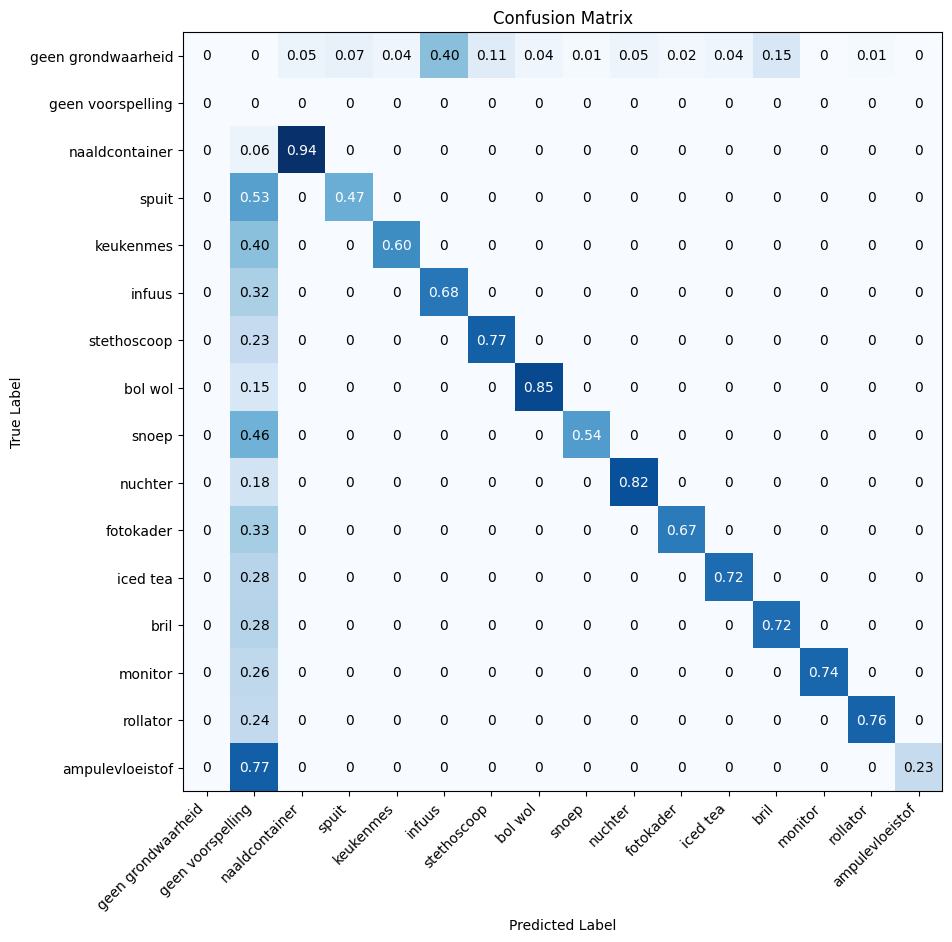

In [78]:
best_grid_search_result = get_best_grid_search_result(
    grid_sesarch_results=grid_search_results,
    metric="micro_f1"
)

render_grid_search_result(
    result=best_grid_search_result
)

Number of false positives: 255
Recording ID: 2fe01600-c057-40ee-8434-4e9e0688ca2d with 72 false positives


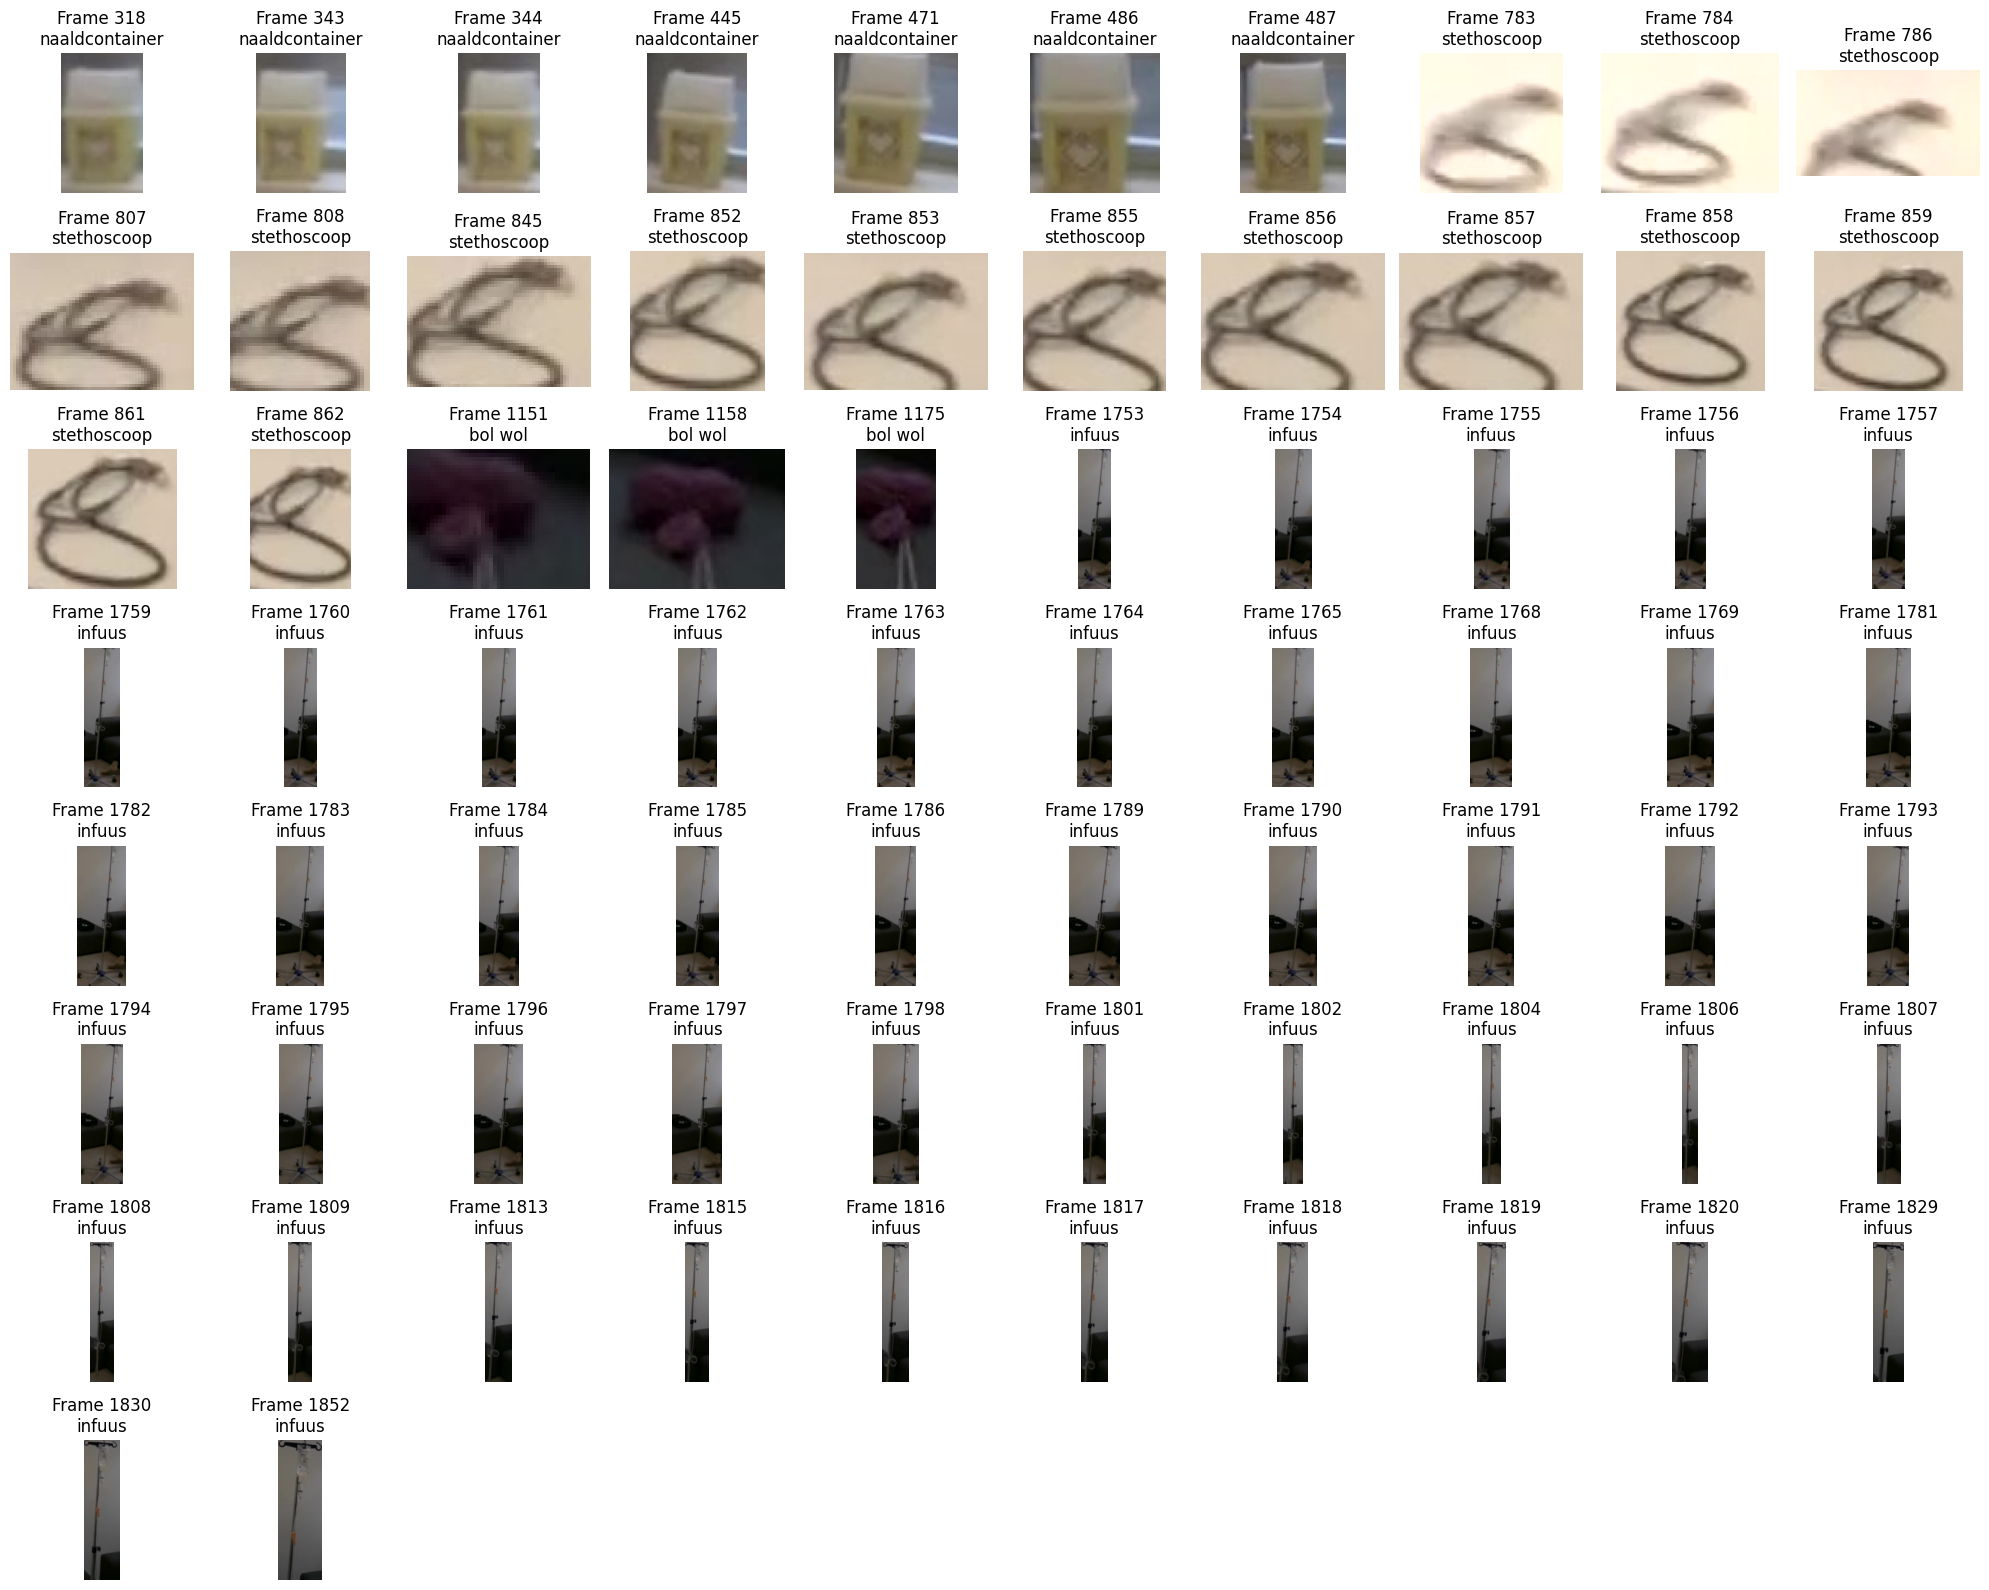

Recording ID: 32f02db7-adc0-4556-a2da-ed2ba60a58c9 with 18 false positives


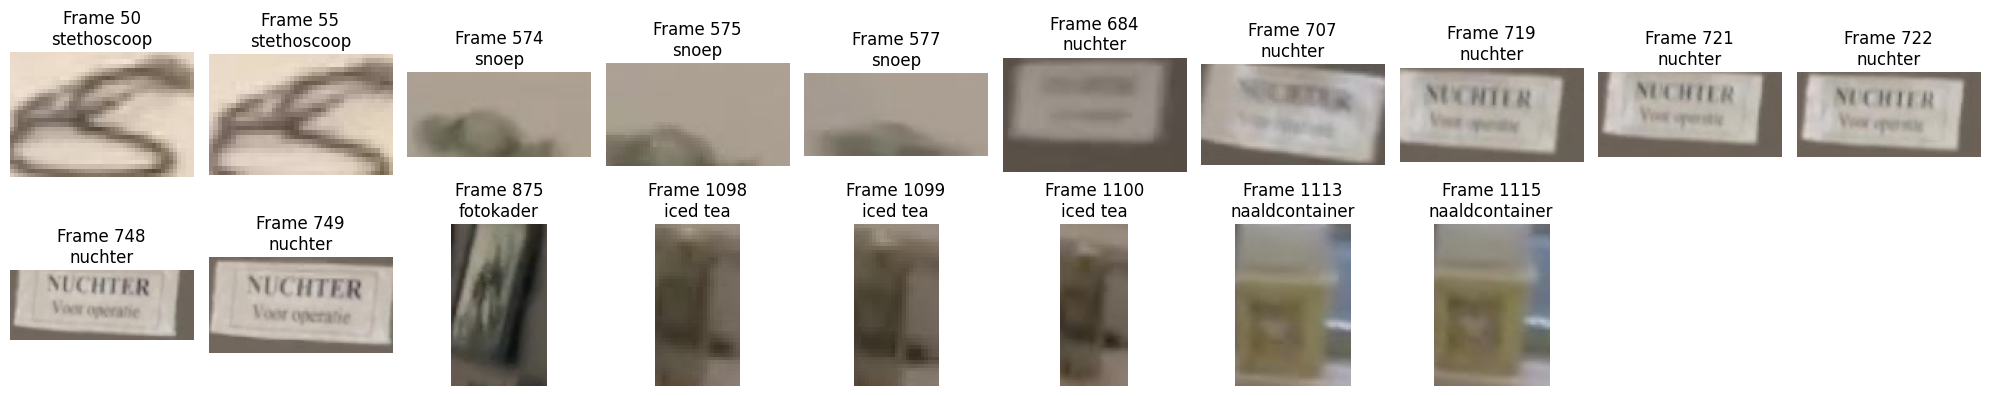

Recording ID: 67823ccd-a1f0-4cde-b954-3b9e5fe160c1 with 15 false positives


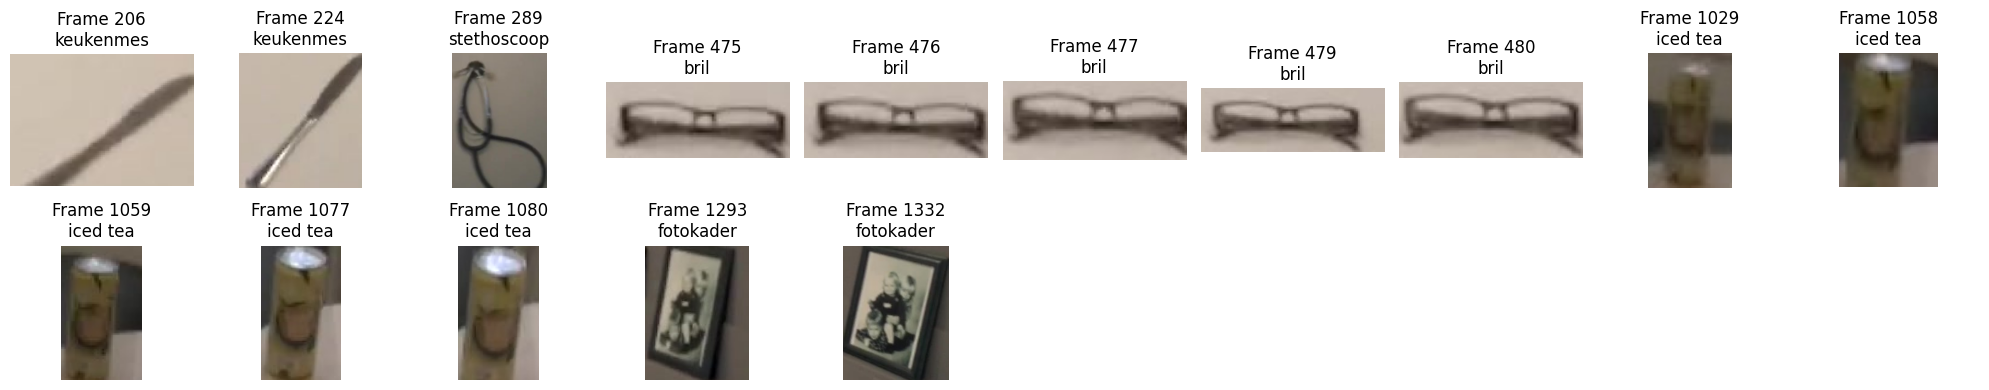

Recording ID: 67b71a70-da64-467a-9fb6-91bc29265fd1 with 12 false positives


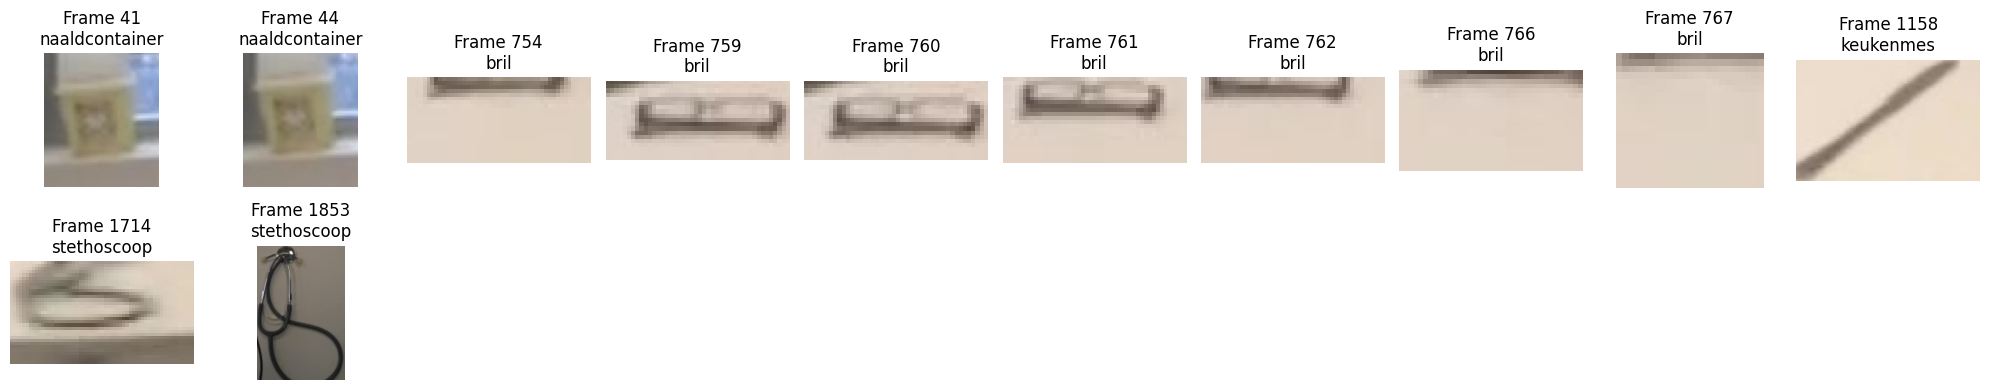

Recording ID: 89b60530-e0e4-4f5d-9ee6-af85c8d99ff4 with 4 false positives


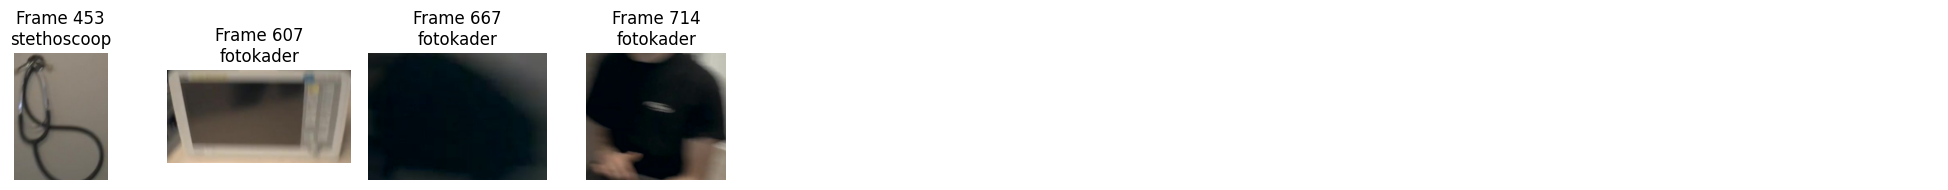

Recording ID: 98128cdc-ffeb-40cb-9528-573e25028e87 with 16 false positives


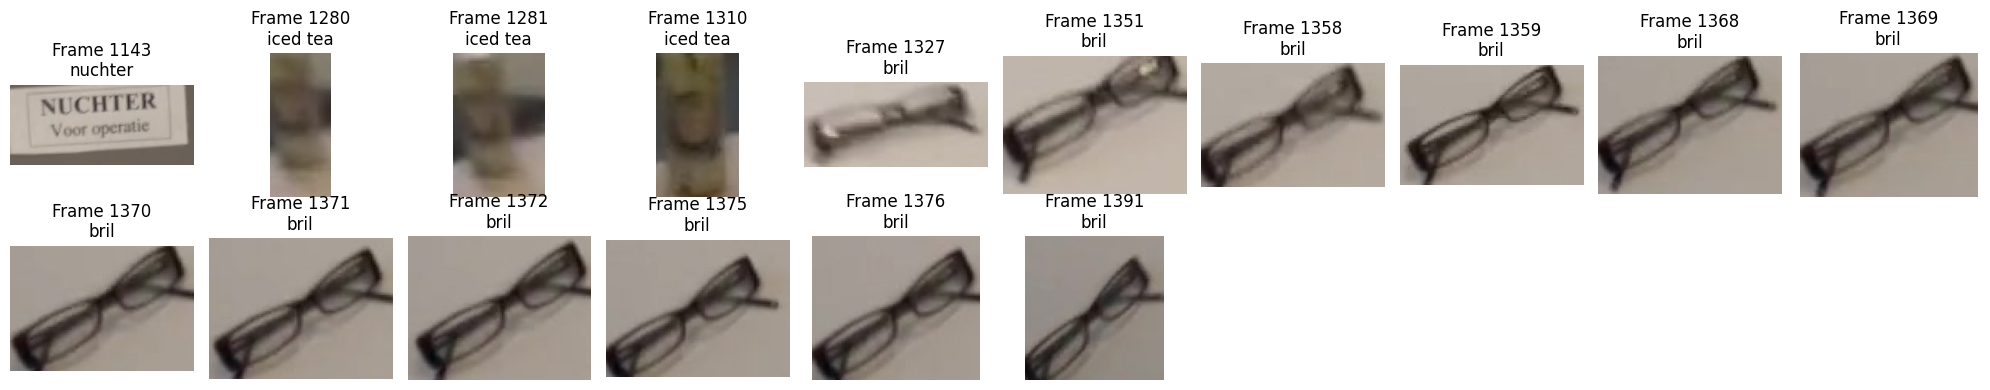

Recording ID: 9fa3e3b8-ed94-4b06-ba49-e66e3997d710 with 19 false positives


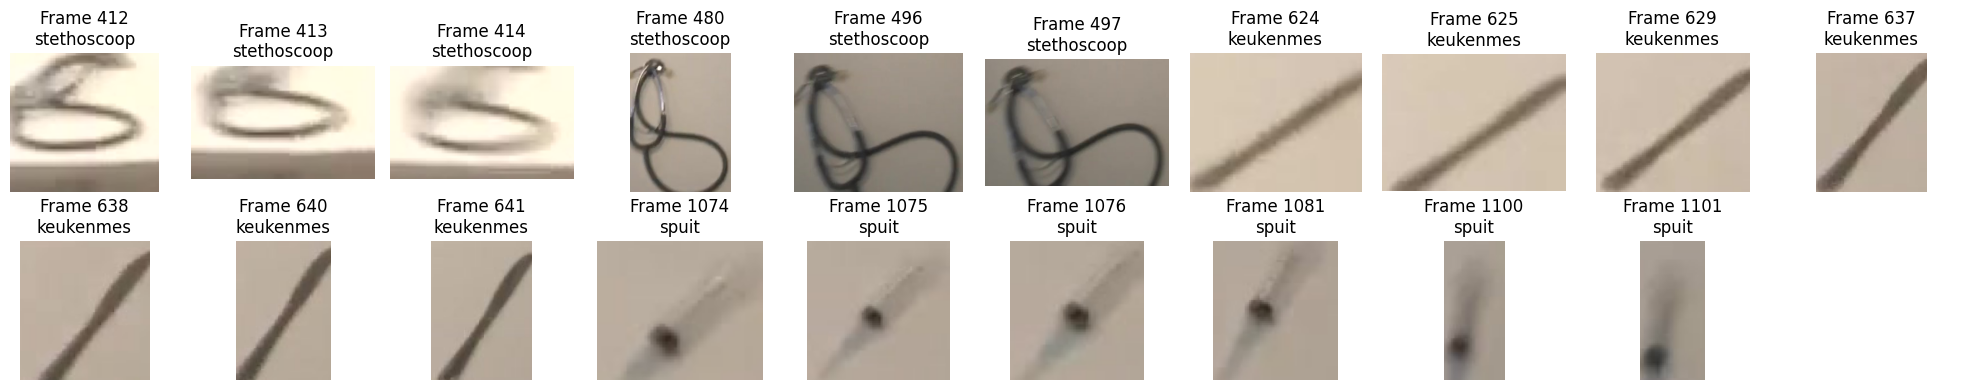

Recording ID: b8eeecc0-06b1-47f7-acb5-89aab3c1724d with 11 false positives


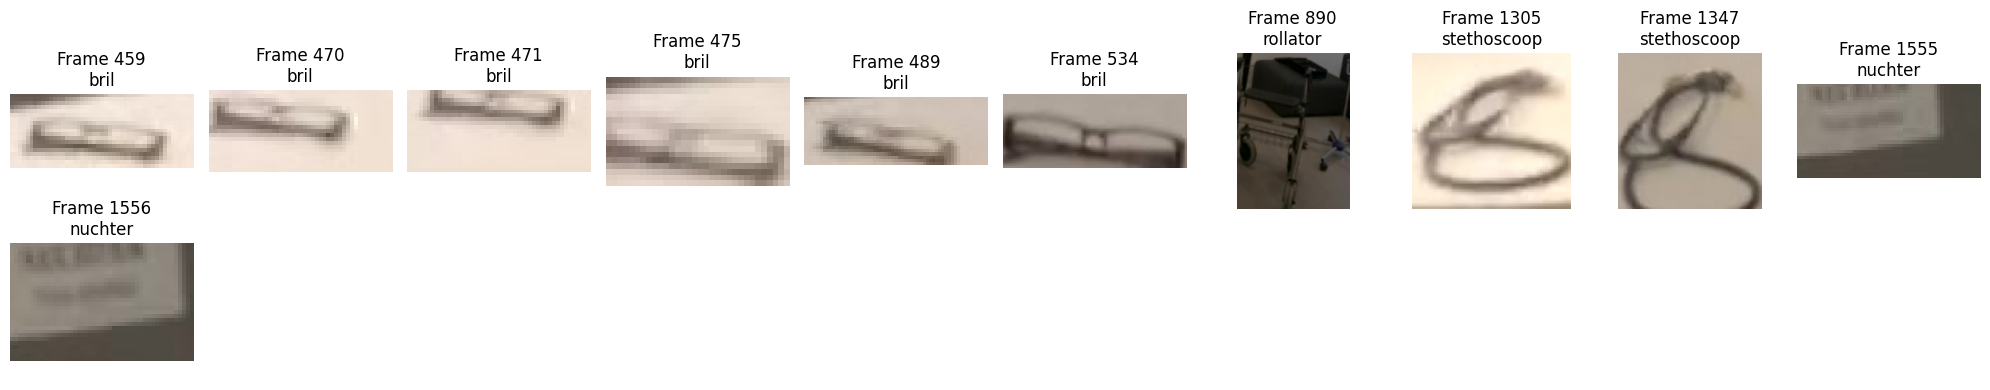

Recording ID: b8f453aa-5a12-4cbb-a0ec-20eb503f8797 with 67 false positives


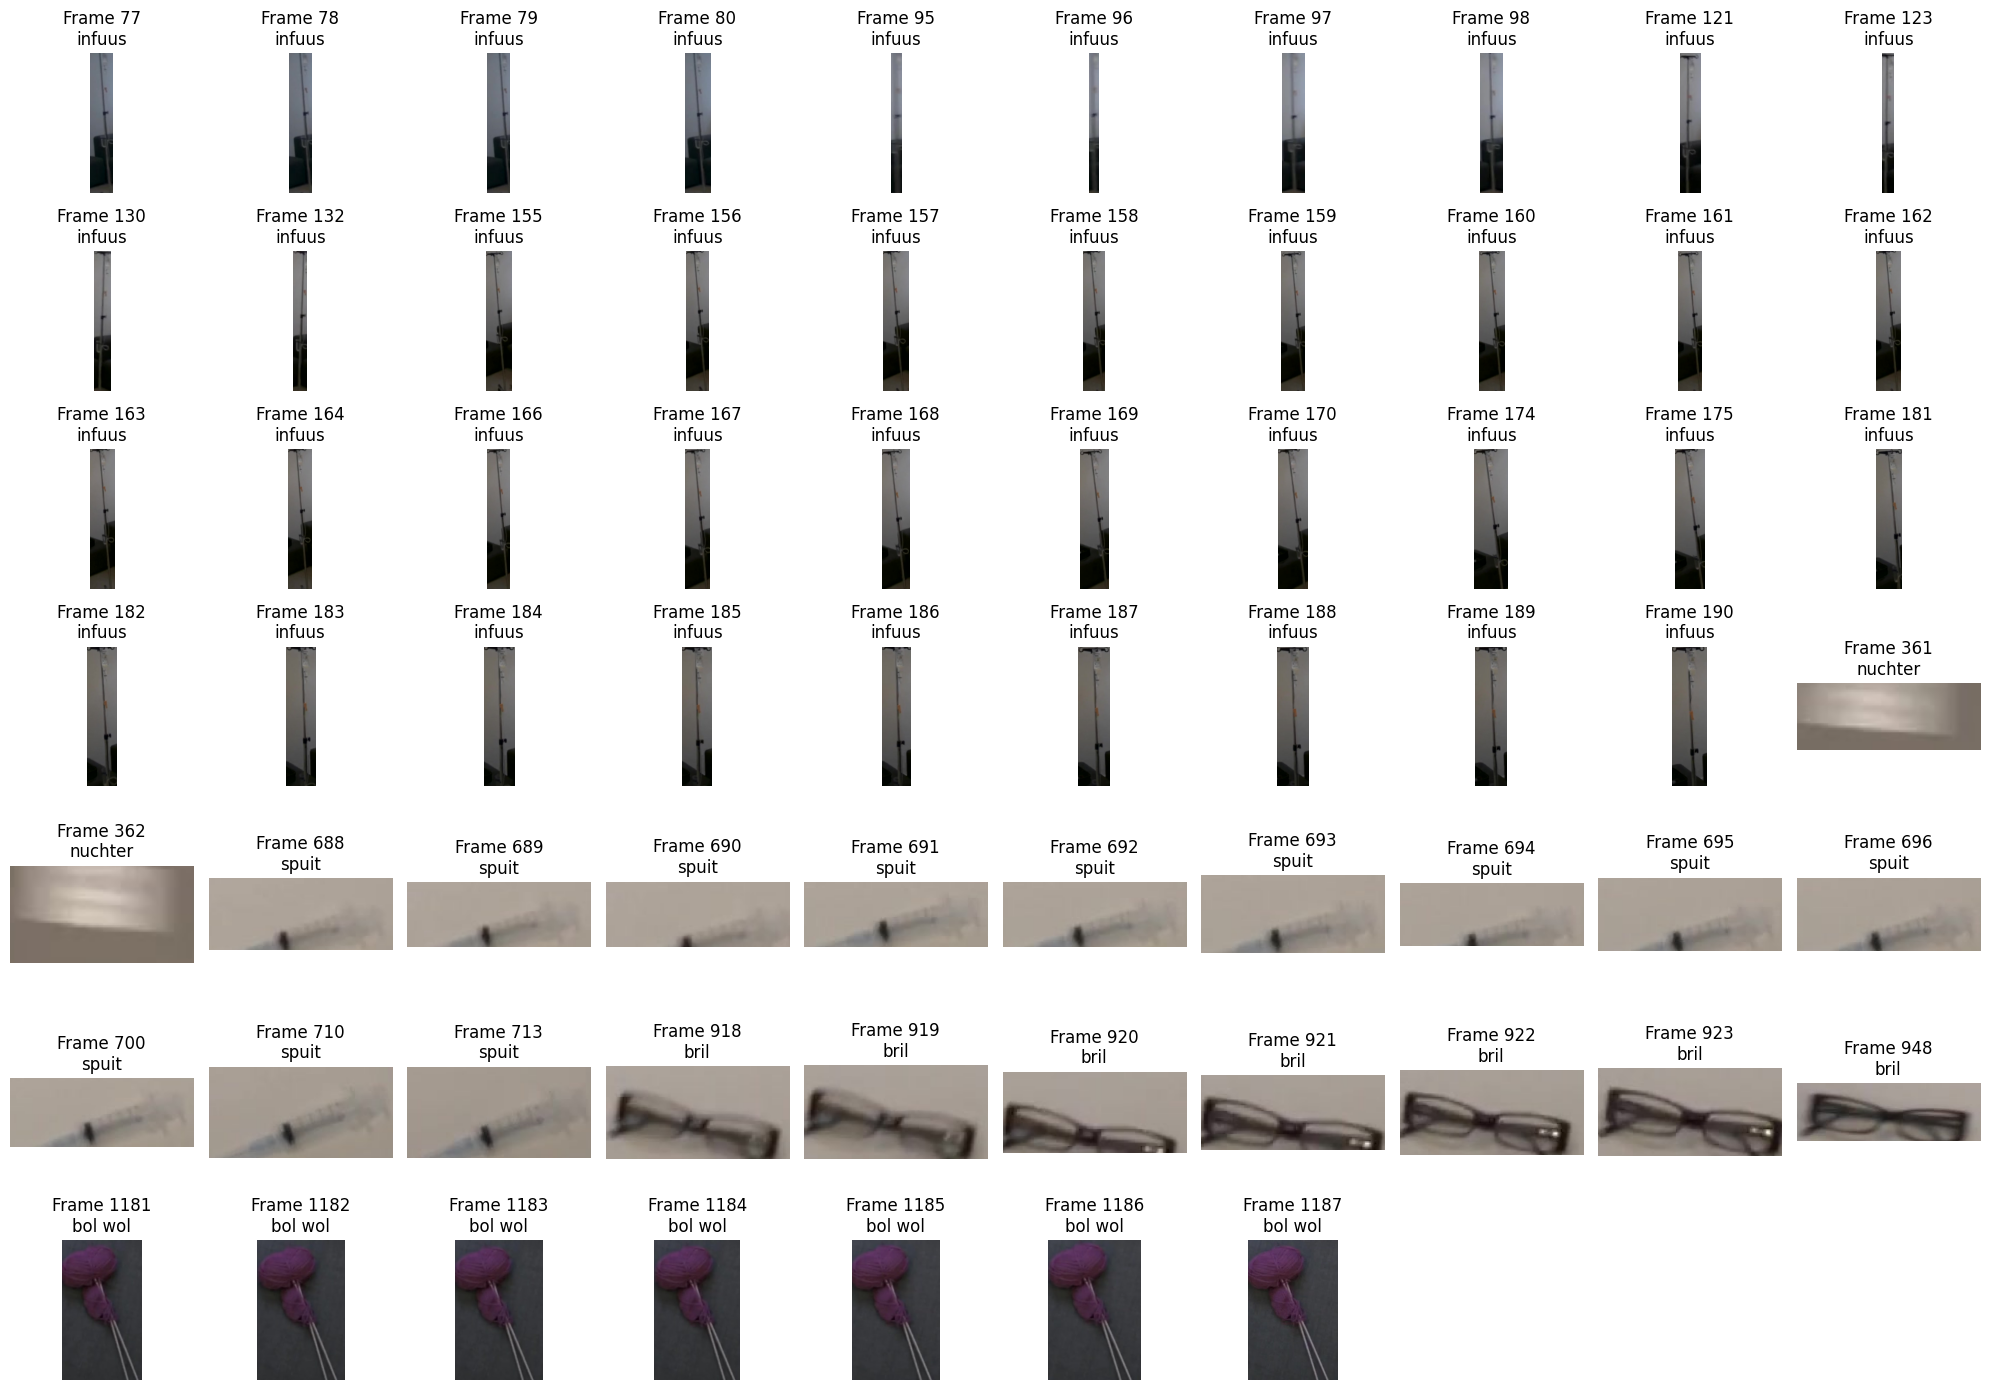

Recording ID: d50c5f3b-2822-4462-9880-5a8f0dd46bfb with 21 false positives


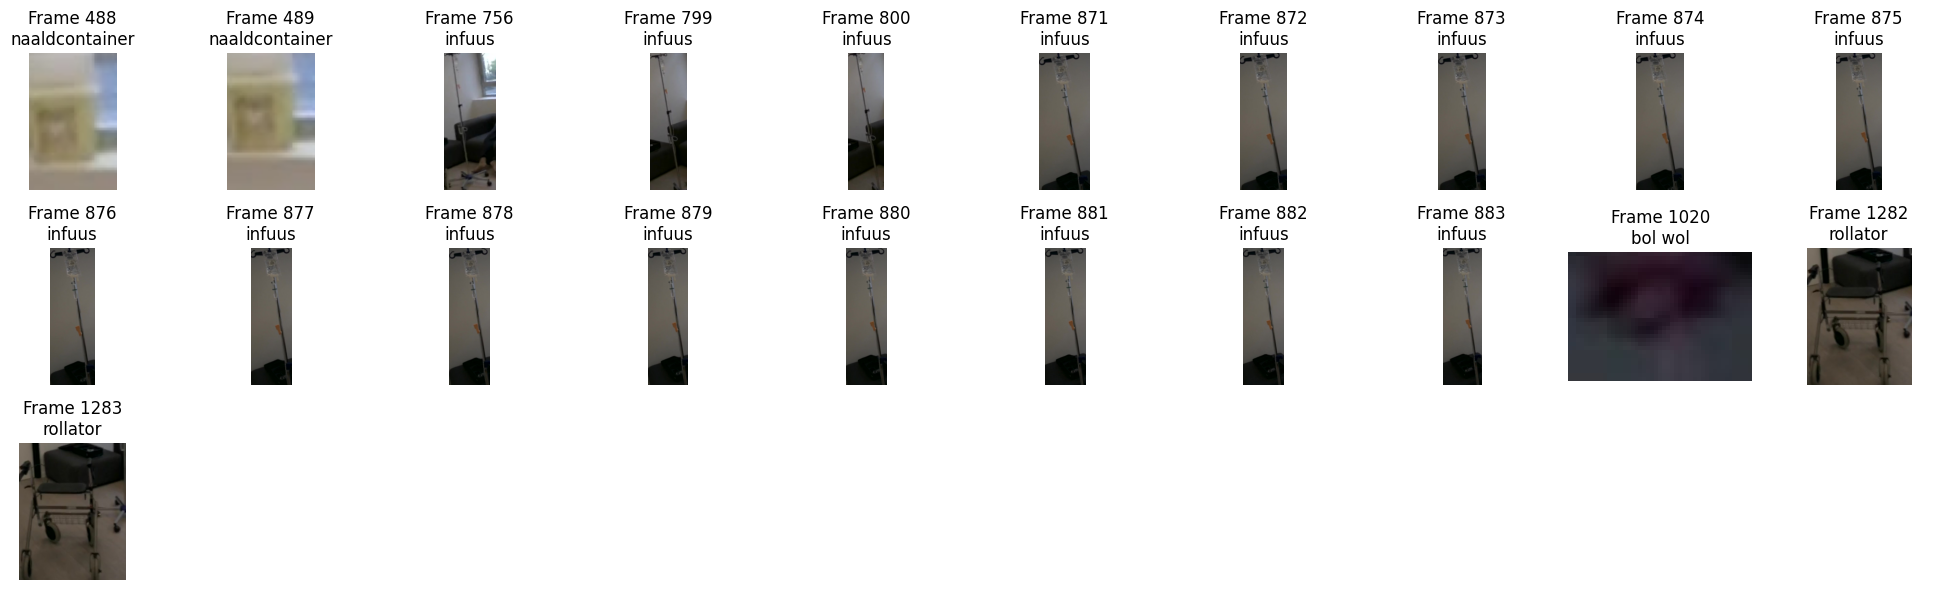

In [80]:
evaluation_df = best_grid_search_result["full_evaluation_df"]
fps_df = evaluation_df[evaluation_df['label'] == 'FP']

print(f"Number of false positives: {len(fps_df)}")

# for each predicted class_id, print the number of false positives
for class_id, group in fps_df.groupby("recording_id"):
    print(f"Recording ID: {class_id} with {len(group)} false positives")

    rois = []
    frame_indexes = []
    pred_class_ids = []

    for idx, row in group.iterrows():
        recording_id = row["recording_id"]
        frame_idx = row["frame_idx"]
        x1, y1, x2, y2 = int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"])

        frame_path = RECORDING_FRAMES_PATH / recording_id / f"{int(frame_idx):05d}.jpg"

        image = cv2.imread(str(frame_path))
        roi = image[y1:y2, x1:x2]
        rois.append(roi)
        frame_indexes.append(frame_idx)
        pred_class_ids.append(row["predicted_class_id"])

    # show all of the ROIs in a 10xN grid, sort by frame index
    rois, frame_indexes = zip(*sorted(zip(rois, frame_indexes), key=lambda x: x[1]))
    rois = list(rois)  # Convert to list for easier manipulation
    frame_indexes = list(frame_indexes)
    n = len(rois)
    n_cols = 10
    n_rows = (n + n_cols - 1) // n_cols  # Ceiling division to get the number of rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 2 * n_rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing
    for i, roi in enumerate(rois):
        axes[i].imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
        axes[i].set_title(f"Frame {int(frame_indexes[i])}\n{CLASS_ID_TO_NAME[pred_class_ids[i]]}", fontsize=12)
    for j in range(i + 1, n_rows * n_cols):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

Model: 2000_samples
Min Pred Conf: 0.7
IoU Threshold: 0.2
Min Glance Frame Count: 5

Overall Accuracy: 0.6694
Micro Precision: 0.9438
Micro Recall: 0.6972
Micro F1: 0.8020

Per Class Metrics:
Class Name Precision  Recall     F1         Support   
naaldcontainer 0.9810     0.9413     0.9607     715       
spuit      0.9234     0.4717     0.6245     460       
keukenmes  0.9617     0.6034     0.7415     416       
infuus     0.7571     0.6839     0.7186     465       
stethoscoop 0.9364     0.7666     0.8430     557       
bol wol    0.9716     0.8529     0.9084     442       
snoep      0.9848     0.5417     0.6989     360       
nuchter    0.9643     0.8244     0.8889     393       
fotokader  0.9774     0.6684     0.7939     389       
iced tea   0.9560     0.7221     0.8227     331       
bril       0.8810     0.7192     0.7919     381       
monitor    1.0000     0.7431     0.8526     506       
rollator   0.9888     0.7564     0.8571     349       
ampulevloeistof 1.0000     0.2287

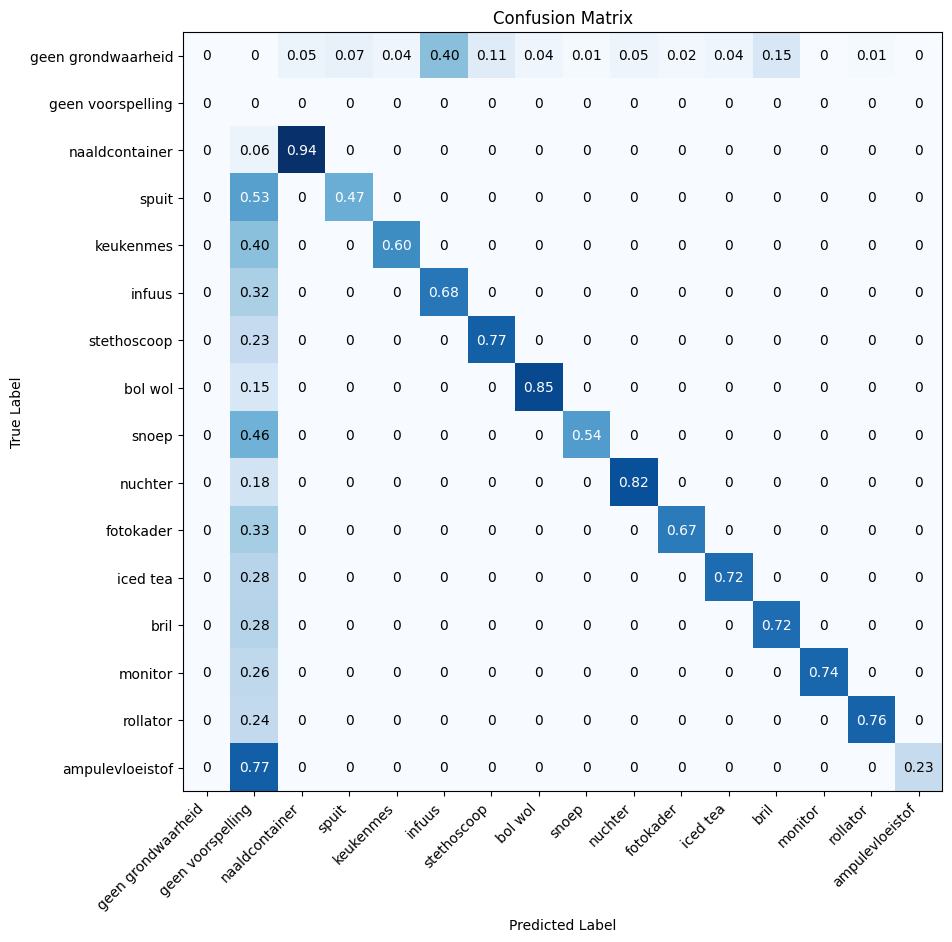

In [ ]:
best_grid_search_result = get_best_grid_search_result(
    grid_sesarch_results=grid_search_results,
    metric="micro_f1"
)

render_grid_search_result(
    result=best_grid_search_result
)

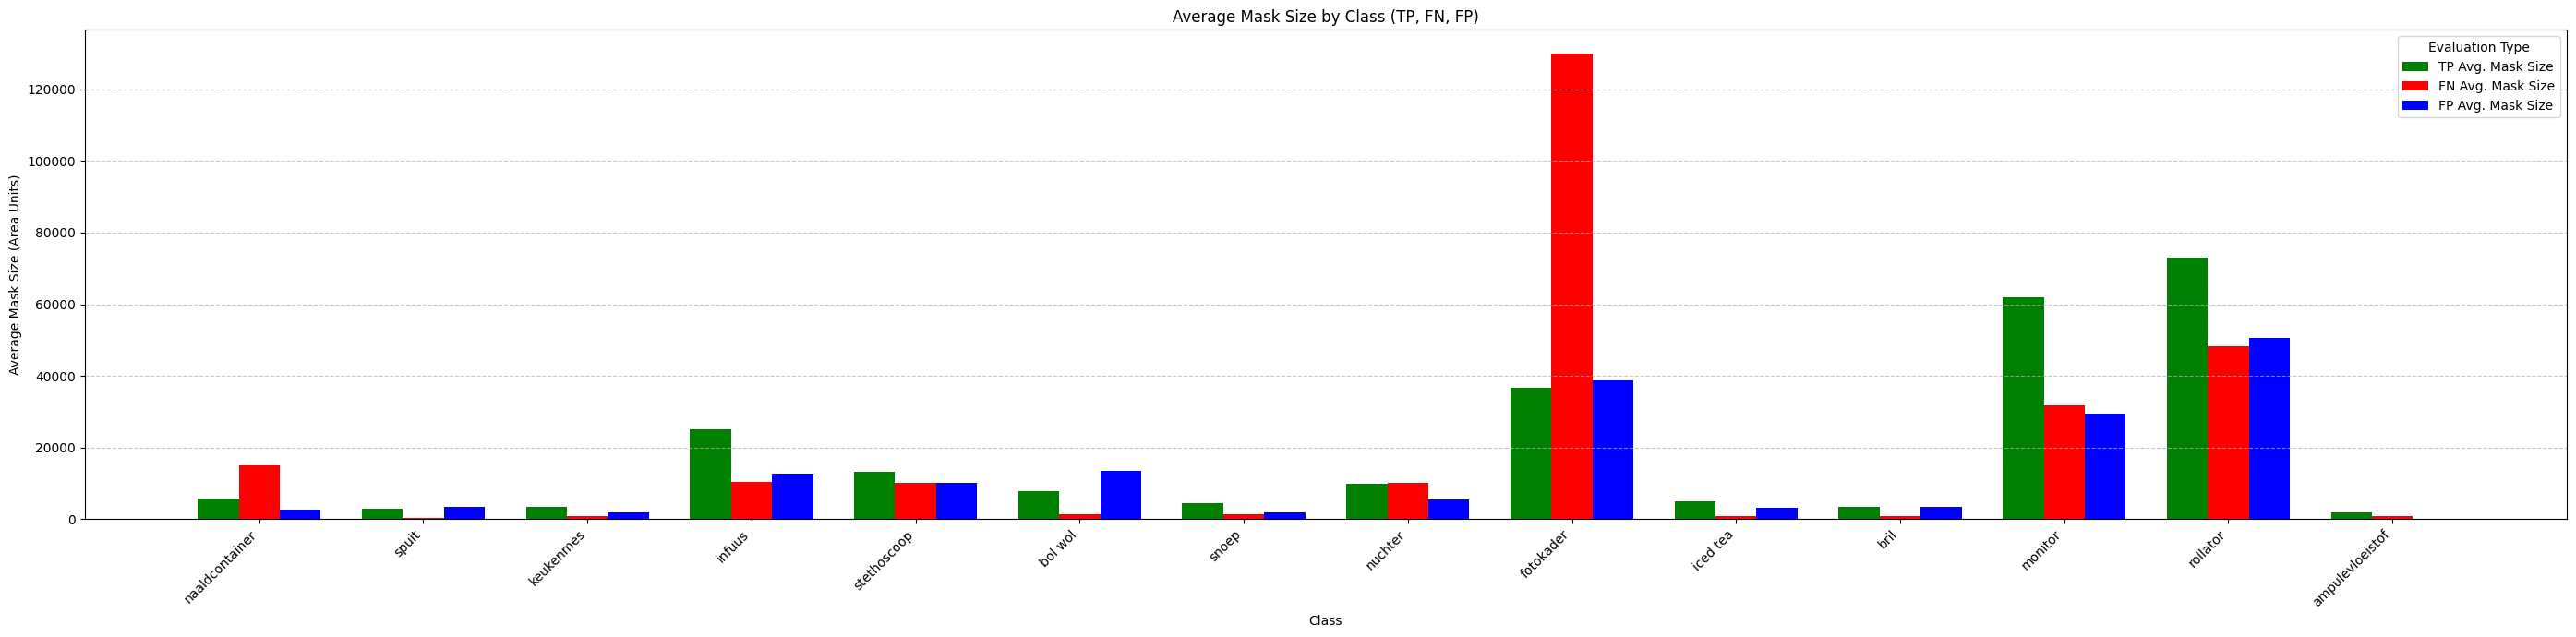

In [10]:
from experiment.settings import MISSING_GROUND_TRUTH_CLASS_ID, MISSING_PREDICTION_CLASS_ID

def plot_avg_mask_size_by_class(
    eval_df: pd.DataFrame,
):
    plot_df = eval_df.copy()
    
    # Filter out rows where target_metric is NaN (e.g., FNs from GTs without bbox info, or invalid bboxes)
    target_metric = "mask_area"
    plot_df = plot_df.dropna(subset=[target_metric])
    if plot_df.empty:
        print(f"No valid data with {target_metric} found in eval_df.")
        return

    tps_df = plot_df[plot_df['label'] == 'TP']
    avg_mask_tp = tps_df.groupby('true_class_id')[target_metric].mean().rename('TP Avg. Mask Size')

    fns_df = plot_df[plot_df['label'] == 'FN']
    avg_mask_fn = fns_df.groupby('true_class_id')[target_metric].mean().rename('FN Avg. Mask Size')

    fps_df = plot_df[plot_df['label'] == 'FP']
    avg_mask_fp = fps_df.groupby('predicted_class_id')[target_metric].mean().rename('FP Avg. Mask Size')
    
    # 3. Merge the series
    plot_data = pd.concat([avg_mask_tp, avg_mask_fn, avg_mask_fp], axis=1)
    
    # Filter out any special class IDs that might have ended up as an index
    # (e.g. if a true_class_id in FNs was accidentally a special ID)
    special_ids_for_index = {UNKNOWN_CLASS_ID, MISSING_GROUND_TRUTH_CLASS_ID, MISSING_PREDICTION_CLASS_ID}
    valid_class_indices = [idx for idx in plot_data.index if idx not in special_ids_for_index and pd.notna(idx)]
    plot_data = plot_data.loc[valid_class_indices]

    if plot_data.empty:
        print("No data available to plot after filtering classes and calculating averages.")
        return

    # Fill NaN with 0 for classes that might not have TPs, FPs, or FNs for mask size.
    plot_data = plot_data.fillna(0)
    plot_data = plot_data.sort_index() # Sort by class ID

    # 4. Plotting
    n_classes = len(plot_data)
    if n_classes == 0:
        print("No classes with valid data to plot.")
        return

    fig, ax = plt.subplots(figsize=(max(10, n_classes * 2), 7)) # Adjust width based on num classes

    bar_width = 0.25
    index = np.arange(n_classes)
    
    # Define colors for bars
    tp_color = 'green'
    fn_color = 'red'
    fp_color = 'blue'

    ax.bar(index - bar_width, plot_data['TP Avg. Mask Size'], bar_width, label='TP Avg. Mask Size', color=tp_color)
    ax.bar(index, plot_data['FN Avg. Mask Size'], bar_width, label='FN Avg. Mask Size', color=fn_color)
    ax.bar(index + bar_width, plot_data['FP Avg. Mask Size'], bar_width, label='FP Avg. Mask Size', color=fp_color)

    ax.set_xlabel('Class')
    ax.set_ylabel('Average Mask Size (Area Units)')
    ax.set_title('Average Mask Size by Class (TP, FN, FP)')
    
    tick_labels = plot_data.index
    tick_labels = [CLASS_ID_TO_NAME.get(cid, str(cid)) for cid in plot_data.index]
    
    ax.set_xticks(index)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right")
    
    ax.legend(title="Evaluation Type")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout()
    plt.show()

evaluation_df = best_grid_search_result["full_evaluation_df"]
plot_avg_mask_size_by_class(evaluation_df)

# Analyze False Negatives in best result

# Render Final Predictions

In [2]:
def draw_video_frames(
    session: Session,
    frames: list[Path],
    frame_to_gaze_position: dict[int, tuple[int, int]],
    predictions_df: pd.DataFrame,
    draw_unknowns: bool = False
):
    # Iterate over frames and draw the annotations on them if they exist
    for frame in tqdm(frames, desc="Drawing annotations on frames"):
        frame_idx = int(frame.stem)
        frame_img = cv2.imread(str(frame))

        # iterate through the predictions with the same frame index
        frame_predictions = predictions_df[predictions_df["frame_idx"] == frame_idx]
        for _, row in frame_predictions.iterrows():
            class_id = int(row["predicted_class_id"])
            class_name = CLASS_ID_TO_NAME[class_id]
            box = (int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"]))

            try:
                simroom_class = simrooms_service.get_simroom_class(session, class_id)
                color = simroom_class.color
            except:
                if draw_unknowns:
                    color = "#FF0000"
                else:
                    continue

            frame_img = image_utils.draw_labeled_box(
                frame_img, box, class_name, color
            )

        # Draw the gaze point on the frame
        if frame_to_gaze_position.get(frame_idx) is not None:
            gx, gy = frame_to_gaze_position[frame_idx]

            cv2.circle(
                frame_img,
                (int(gx), int(gy)),
                radius=VIEWED_RADIUS,
                color=(0, 0, 255),
                thickness=2,
            )

        # Save the modified image back to its original location
        cv2.imwrite(str(frame), frame_img)

In [9]:
for model in models:
    model_name = model.stem
    model = YOLO(model)
    
    if FINAL_PREDICTION_VIDEOS_PATH.exists():
        shutil.rmtree(FINAL_PREDICTION_VIDEOS_PATH)
    FINAL_PREDICTION_VIDEOS_PATH.mkdir(parents=True, exist_ok=True)

    prediction_results = (OBJECT_DETECTION_PREDICTIONS_PATH / model_name).iterdir()
    for prediction_result_path in prediction_results:
        recording_id = prediction_result_path.stem
        predictions_df = pd.read_csv(prediction_result_path)

        video_path = RECORDINGS_PATH / f"{recording_id}.mp4"

        frames, tmp_frames_dir = simrooms_service.extract_tmp_frames(recording_id)
        tmp_frames_path = Path(tmp_frames_dir.name)

        frame_to_gaze_position = gaze_service.get_gaze_position_per_frame(recording_id, len(frames))

        with Session(engine) as session:
            draw_video_frames(
                session=session,
                frames=frames,
                frame_to_gaze_position=frame_to_gaze_position,
                predictions_df=predictions_df,
            )

        print(f"Creating video for {recording_id}")
        video_result_path = FINAL_PREDICTION_VIDEOS_PATH / f"{recording_id}.mp4"
        cmd = f'ffmpeg -hwaccel cuda -y -pattern_type glob -framerate {TOBII_GLASSES_FPS} -i "{str(tmp_frames_path)!s}/*.jpg" -c:v libx264 -pix_fmt yuv420p "{str(video_result_path)}"'
        subprocess.run(cmd, shell=True)


Drawing annotations on frames: 100%|██████████| 1365/1365 [00:10<00:00, 127.80it/s]
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheo

Creating video for 32f02db7-adc0-4556-a2da-ed2ba60a58c9


Stream mapping:
  Stream #0:0 -> #0:0 (mjpeg (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[libx264 @ 0x55d7c25c7940] using SAR=1/1
[libx264 @ 0x55d7c25c7940] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2 AVX512
[libx264 @ 0x55d7c25c7940] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x55d7c25c7940] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=24 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=24 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1

Creating video for 67b71a70-da64-467a-9fb6-91bc29265fd1


Stream mapping:
  Stream #0:0 -> #0:0 (mjpeg (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[libx264 @ 0x55d653650380] using SAR=1/1
[libx264 @ 0x55d653650380] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2 AVX512
[libx264 @ 0x55d653650380] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x55d653650380] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=24 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=24 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1

Drawing annotations on frames: 100%|██████████| 1557/1557 [00:11<00:00, 132.72it/s]
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheo

Creating video for b8eeecc0-06b1-47f7-acb5-89aab3c1724d


Stream mapping:
  Stream #0:0 -> #0:0 (mjpeg (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[libx264 @ 0x56058b8b4b00] using SAR=1/1
[libx264 @ 0x56058b8b4b00] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2 AVX512
[libx264 @ 0x56058b8b4b00] profile High, level 4.0, 4:2:0, 8-bit
[libx264 @ 0x56058b8b4b00] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=24 lookahead_threads=4 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=24 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1